In [ ]:
# cell 1
import os
import time
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.signal import argrelextrema
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
from mplfinance.original_flavor import candlestick_ohlc

# ensure output folder
os.makedirs("scanner_output", exist_ok=True)

def compute_rsi(close, period=14):
    delta = close.diff()
    gain  = delta.clip(lower=0)
    loss  = -delta.clip(upper=0)
    avg_gain = gain.ewm(alpha=1/period, adjust=False).mean()
    avg_loss = loss.ewm(alpha=1/period, adjust=False).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

# ————————————— Compute MACD —————————————
def compute_macd(df, fast=12, slow=26, signal=9):
    ema_fast   = df["close"].ewm(span=fast,  adjust=False).mean()
    ema_slow   = df["close"].ewm(span=slow,  adjust=False).mean()
    macd_line  = ema_fast - ema_slow
    sig_line   = macd_line.ewm(span=signal, adjust=False).mean()
    hist       = macd_line - sig_line
    df["macd"]         = macd_line
    df["macd_signal"]  = sig_line
    df["macd_hist"]    = hist
    return df

def volume_metrics(df, vol_spike_ratio=1.5, vol_avg_window=20):
    df["avg_vol"]   = df["volume"].rolling(vol_avg_window, min_periods=1).mean()
    df["vol_spike"] = df["volume"] > vol_spike_ratio * df["avg_vol"]
    return df

def local_extrema(df, kind="min", order=5):
    func = np.less_equal if kind=="min" else np.greater_equal
    idx  = argrelextrema(df["close"].values, func, order=order)[0]
    return df.iloc[idx]

def find_trendlines(df, extrema, tolerance=1.5, min_touches=3):
    x = extrema.index.to_numpy(dtype=float)
    y = extrema["close"].to_numpy(dtype=float)
    lines = []
    n = len(x)
    if n < 2:
        return lines

    for i in range(n - 1):
        for j in range(i + 1, n):
            x1, x2 = x[i], x[j]
            y1, y2 = y[i], y[j]
            if x2 == x1:
                continue
            m = (y2 - y1) / (x2 - x1)
            b = y1 - m * x1

            # which extrema lie within tolerance of the line?
            mask = np.abs(y - (m * x + b)) < tolerance
            touches = int(mask.sum())
            if touches < min_touches:
                continue

            # compute span = max(x[mask]) - min(x[mask])
            # old: span = float(x[mask].ptp())
            span = float(np.ptp(x[mask]))

            lines.append({
                "slope":     float(m),
                "intercept": float(b),
                "touches":   touches,
                "span":      span
            })

    return lines

def signal_on_last(df, lines, is_support=True):
    """Returns list of (type,m,b,price_today)"""
    sigs = []
    c = df["close"].to_numpy(dtype=float)
    if c.size<2: return sigs
    p_yest, p_today = c[-2], c[-1]
    i_yest, i_today = c.size-2, c.size-1
    for L in lines:
        m,b = L if isinstance(L, tuple) else (L["slope"],L["intercept"])
        ly = m*i_yest + b
        lt = m*i_today + b
        if is_support and p_yest<ly and p_today>lt:
            sigs.append(("Buy", m,b, float(p_today)))
        if not is_support and p_yest>ly and p_today<lt:
            sigs.append(("Sell",m,b, float(p_today)))
    return sigs

def backtest_flip(signals, closes):
    c = closes.to_numpy(dtype=float)
    if c.size<2 or not signals:
        return dict(trades=0,
                    win_rate=np.nan,
                    cum_ret=0.0,
                    buy_hold=(c[-1]-c[0])/c[0]*100 if c.size>1 else 0.0)
    sigs = sorted(signals, key=lambda s:s[3])
    pos = None; entry=None; returns=[]
    for _,typ,m,b, _ in [(s[0],s[0],s[1],s[2],s[3]) for s in sigs]:
        # always evaluate exit at last price
        px = c[-1]
        if pos is None:
            pos = typ
            entry = px
        else:
            ret = (px-entry)/entry if pos=="Buy" else (entry-px)/entry
            returns.append(ret)
            pos = typ; entry=px
    # final exit
    final = c[-1]
    returns.append((final-entry)/entry if pos=="Buy" else (entry-final)/entry)
    wins = [r for r in returns if r>0]
    return dict(trades=len(returns),
                win_rate=len(wins)/len(returns)*100,
                cum_ret=(np.prod([1+r for r in returns])-1)*100,
                buy_hold=(c[-1]-c[0])/c[0]*100)

def is_hammer(open_, high, low, close):
    body  = abs(close - open_)
    lower = min(open_, close) - low
    upper = high - max(open_, close)
    total = high - low

    # lower shadow at least twice the body,
    # upper shadow very small, body small vs range
    return (
        lower > 2 * body and
        upper < 0.3 * body and
        body < 0.3 * total
    )

def backtest_signal(df, col):
    bt = df[["date","ret",col]].copy()
    bt["pos"] = 0
    bt.loc[bt[col]=="Buy",  "pos"] = 1
    bt.loc[bt[col]=="Sell", "pos"] = 0
    bt["pos"] = bt["pos"].ffill().shift().fillna(0)
    bt["strat_ret"]    = bt["pos"] * bt["ret"]
    bt["cumret_strat"] = (1 + bt["strat_ret"]).cumprod() - 1
    return bt


In [105]:
import yfinance as yf

tickers = ["AAPL","NVDA","SPY","PLTR", "ZIM", "SHOP", "SOFI", "ONDS", "RCAT", "HOOD", "AMZN", "META", "CMG", "NOC", "RGTI", "MMM", 
           "MO", "WING", "CGC", "GOOGL", "ARWR", "ARM", "FBIO", "AGI", "V", "EFR", "AVAV", "LMT", "TSM", "TSLA", "MSFT", 
           "GRRR", "IONQ", "BBAI", "LRCX", "AI"]
data = {}

for tk in tickers:
    df = (
        yf.download(tk, period="6mo", interval="1d", progress=False)
          .dropna()
          .reset_index()                         # pull “Date” back out of the index
    )
    # if you want to use adjusted-close as your “close” price:
    # df["close"] = df["adj_close"]
    # df = df.drop(columns="adj_close")
    
    # tack on a ticker column
    df["ticker"] = tk
    
    # reorder however you like
    df.columns = ['date', 'close', 'high', 'low', 'open', 'volume', 'stock']
    
    data[tk] = df

# now
data["AAPL"].head()


,date,close,high,low,open,volume,stock
0,2024-10-24,230.063660,230.313111,227.908400,229.474944,31109500,AAPL
1,2024-10-25,230.901810,232.707832,229.065854,229.235479,38802300,AAPL
2,2024-10-28,232.887436,234.214517,232.039312,232.807625,36087100,AAPL
3,2024-10-29,233.156845,233.815399,231.809819,232.588105,35417200,AAPL
4,2024-10-30,229.594696,232.957290,229.045901,232.099178,47070900,AAPL


In [89]:
df = data['NVDA']

In [110]:

log_path = "scanner_output/signals_log.csv"
os.makedirs(os.path.dirname(log_path), exist_ok=True)

summaries = []
all_logs   = []

for ticker, df in data.items():
    # ensure sorted index and easy integer‐based trendline math
    df = df.sort_values("date").reset_index(drop=True)
    df["ticker"] = ticker

    # 1) Indicators
    df["rsi_14"] = compute_rsi(df["close"], period=14)
    df["rsi_signal"] = np.where(df["rsi_14"] < 30, "oversold",
                         np.where(df["rsi_14"] > 70, "overbought", "neutral"))

    df = compute_macd(df)
    df["macd_cross"] = np.where(
        (df["macd"].shift(1) < df["macd_signal"].shift(1)) &
        (df["macd"]     > df["macd_signal"]),
        "bull_cross",
        np.where(
            (df["macd"].shift(1) > df["macd_signal"].shift(1)) &
            (df["macd"]     < df["macd_signal"]),
            "bear_cross",""
        )
    )

    df = volume_metrics(df)

    # 2) Trendlines & distances
    lows      = local_extrema(df, "min", order=5)
    highs     = local_extrema(df, "max", order=5)
    sup_cands = find_trendlines(df, lows,  tolerance=1.5, min_touches=3)
    res_cands = find_trendlines(df, highs, tolerance=1.5, min_touches=3)
    sup_cands.sort(key=lambda L:(L["touches"],L["span"]), reverse=True)
    res_cands.sort(key=lambda L:(L["touches"],L["span"]), reverse=True)
    top_sup, top_res = sup_cands[:2], res_cands[:2]

    if top_sup and top_res:
        m_sup, b_sup = top_sup[0]["slope"], top_sup[0]["intercept"]
        m_res, b_res = top_res[0]["slope"], top_res[0]["intercept"]
        x = np.arange(len(df), dtype=float)
        df["dist_sup"] = np.abs(df["close"] - (m_sup * x + b_sup))
        df["dist_res"] = np.abs(df["close"] - (m_res * x + b_res))
    else:
        df["dist_sup"] = df["dist_res"] = np.nan

    # 3) Per‐row trendline breakout
    trendline_signals = []
    breakthrough_signals = []
    for i in range(len(df)):
        # slice for signal_on_last
        slice_df = df.iloc[:i+1]
        sup_hit = bool(signal_on_last(slice_df, top_sup, True))
        res_hit = bool(signal_on_last(slice_df, top_res, False))
        ds = df.at[i, "dist_sup"]
        dr = df.at[i, "dist_res"]

        # trendline_signal w/ distance
        if sup_hit and ds <= dr:
            trendline_signals.append("Buy")
        elif res_hit and dr <= ds:
            trendline_signals.append("Sell")
        else:
            trendline_signals.append("")

        # breakthrough (reversal) signal
        if i==0:
            breakthrough_signals.append("")
            continue
        p_yest, p_today = df.at[i-1,"close"], df.at[i,"close"]
        ly_res_yest   = m_res*(i-1) + b_res
        ly_res_today  = m_res*i     + b_res
        ly_sup_yest   = m_sup*(i-1) + b_sup
        ly_sup_today  = m_sup*i     + b_sup

        # reversal up through resistance?
        if (p_yest < ly_res_yest 
            and p_today > ly_res_today 
            and df.at[i,"dist_res"] <= df.at[i,"dist_sup"]):
            breakthrough_signals.append("reversal_up")

        # reversal down through support?
        elif (p_yest > ly_sup_yest 
              and p_today < ly_sup_today 
              and df.at[i,"dist_sup"] <= df.at[i,"dist_res"]):
            breakthrough_signals.append("reversal_down")
        else:
            breakthrough_signals.append("")

    df["trendline_signal"]     = trendline_signals
    df["breakthrough_signal"]  = breakthrough_signals

    # 4) Composite (optional—you can skip if not needed)
    df["composite_signal"] = ""
    buy_mask = (
        (df["trendline_signal"]=="Buy") &
        (df["macd_cross"]       =="bull_cross") &
        (df["rsi_14"]           < 30)             &
        (df["dist_sup"]         <= df["dist_res"])
    )
    sell_mask = (
        (df["trendline_signal"]=="Sell") &
        (df["macd_cross"]       =="bear_cross") &
        (df["rsi_14"]           > 70)            &
        (df["dist_res"]         <= df["dist_sup"])
    )
    df.loc[buy_mask,  "composite_signal"] = "Buy"
    df.loc[sell_mask, "composite_signal"] = "Sell"

    # 5) Backtest both signals vs. BH
    df["ret"] = df["close"].pct_change()
    df["cumret_bh"] = (1 + df["ret"]).cumprod() - 1

    trend_bt = backtest_signal(df, "trendline_signal")
    rev_bt   = backtest_signal(df, "breakthrough_signal")

    summaries.append({
        "ticker": ticker,
        "bh_return":    df["cumret_bh"].iat[-1],
        "trend_return": trend_bt["cumret_strat"].iat[-1],
        "breakout_return": rev_bt["cumret_strat"].iat[-1],
    })

    # 6) Collect logs: any bar where ANY of your signals fired
    signal_cols = [
        "rsi_signal", "macd_cross",
        "trendline_signal", "composite_signal",
        "breakthrough_signal"
    ]
    log_df = df[["date","ticker","close"] + signal_cols].copy()
    # keep only rows where at least one signal is non-empty
    mask_any = log_df[signal_cols].apply(lambda row: row.str.len().gt(0).any(), axis=1)
    log_df = log_df[mask_any]
    all_logs.append(log_df)

    data[ticker] = df

# 7) Write / append log CSV
logs = pd.concat(all_logs, ignore_index=True)
if os.path.exists(log_path):
    old = pd.read_csv(log_path, parse_dates=["date"])
    logs = pd.concat([old, logs], ignore_index=True)
# drop exact duplicates
logs = logs.drop_duplicates(subset=["date","ticker","close"]+signal_cols)
logs.to_csv(log_path, index=False)

# 8) Summary table
summary_df = pd.DataFrame(summaries).set_index("ticker")
print(summary_df)




        bh_return  trend_return  breakout_return
ticker                                          
AAPL    -0.110681      0.000000              0.0
NVDA    -0.268382      0.166456              0.0
SPY     -0.069750      0.012506              0.0
PLTR     1.314509      0.000000              0.0
ZIM     -0.114122     -0.049679              0.0
SHOP     0.139564      0.006912              0.0
SOFI     0.074108      0.001413              0.0
ONDS    -0.078884     -0.088014              0.0
RCAT     0.838235      0.000000              0.0
HOOD     0.640705     -0.069678              0.0
AMZN    -0.031012      0.029989              0.0
META    -0.082122      0.012067              0.0
CMG     -0.179677      0.001084              0.0
NOC     -0.089570      0.000000              0.0
RGTI     6.591666     -0.285453              0.0
MMM      0.086885     -0.001981              0.0
MO       0.216942      0.031273              0.0
WING    -0.396484      0.076590              0.0
CGC     -0.747454   

# Calculate returns and Backtest

In [111]:
data['NVDA'].head()

,date,close,high,low,open,volume,stock,ticker,rsi_14,rsi_signal,...,macd_cross,avg_vol,vol_spike,dist_sup,dist_res,trendline_signal,breakthrough_signal,composite_signal,ret,cumret_bh
0,2024-10-24,140.387421,141.327272,138.437737,140.797358,172354900,NVDA,NVDA,NaN,neutral,...,,172354900.0,False,3.334501,14.548325,,,,NaN,NaN
1,2024-10-25,141.517227,144.106822,140.777356,140.907325,205122100,NVDA,NVDA,100.000000,overbought,...,,188738500.0,False,1.814595,13.067836,,,,0.008048,0.008048
2,2024-10-28,140.497391,143.116964,140.027465,142.976987,173586700,NVDA,NVDA,93.507254,overbought,...,,183687900.0,False,2.444332,13.736991,,,,-0.007206,0.000783
3,2024-10-29,141.227280,142.237112,138.877652,140.267427,157593600,NVDA,NVDA,93.816683,overbought,...,,177164325.0,False,1.324344,12.656420,,,,0.005195,0.005982
4,2024-10-30,139.317581,140.307427,136.787989,139.517546,179418100,NVDA,NVDA,82.710027,overbought,...,bear_cross,177615080.0,False,2.843943,14.215437,,,,-0.013522,-0.007621


In [117]:
import os
import matplotlib.pyplot as plt

os.makedirs("scanner_output/bt_graphs", exist_ok=True)

# decide order: tickers with a live signal first
live, no_live = [], []
for tk, df in data.items():
    last_trend = df["composite_signal"].iat[-1]
    last_break = df["breakthrough_signal"].iat[-1]
    if last_trend or last_break:
        live.append(tk)
    else:
        no_live.append(tk)
plot_order = live + no_live

# save summary if you haven’t already
summary_df.to_csv("scanner_output/backtest_summary.csv")

# loop through in the desired order
for ticker in plot_order:
    df = data[ticker]

    # 1) Compute returns & buy-and-hold
    df["ret"]       = df["close"].pct_change()
    df["cumret_bh"] = (1 + df["ret"]).cumprod() - 1

    # 2) Backtest helper (you can define this once outside the loop)
    def backtest_signal(df, signal_col):
        bt = df[["date", "ret", signal_col]].copy()
        bt["pos"] = 0
        bt.loc[bt[signal_col] == "Buy",  "pos"] = 1
        bt.loc[bt[signal_col] == "Sell", "pos"] = 0
        bt["pos"] = bt["pos"].ffill().shift().fillna(0)
        bt["strat_ret"]    = bt["pos"] * bt["ret"]
        bt["cumret_strat"] = (1 + bt["strat_ret"]).cumprod() - 1
        return bt

    trend_bt = backtest_signal(df, "trendline_signal")
    rev_bt   = backtest_signal(df, "breakthrough_signal")

    # 3) Plot on one axes
    fig, ax = plt.subplots(figsize=(10,6))
    ax.plot(df["date"],       df["cumret_bh"],     label="Buy & Hold",    linewidth=2)
    ax.plot(trend_bt["date"], trend_bt["cumret_strat"], label="Trendline Signal", linestyle="--")
    ax.plot(rev_bt["date"],   rev_bt["cumret_strat"],   label="Breakthrough Signal", linestyle=":")

    ax.set_title(f"{ticker} Cumulative Returns")   # ticker in the title
    ax.set_xlabel("Date")
    ax.set_ylabel("Cumulative Return")
    ax.legend()
    ax.grid(True)

    # 4) Save and close—no display
    out_path = f"scanner_output/bt_graphs/{ticker}_cumret.png"
    fig.savefig(out_path, dpi=150, bbox_inches="tight")
    plt.close(fig)



In [100]:
df[df['position']=='1']

,date,close,high,low,open,volume,stock,rsi_14,rsi_signal,macd,...,up_bar,hammer,log_ret,cum_log_bh,cumret_bh_log,ret,cumret_bh,position,ret_strat,cumret_strat


In [92]:
# df = data['NVDA']

# Graph prices, vol, macd and signals

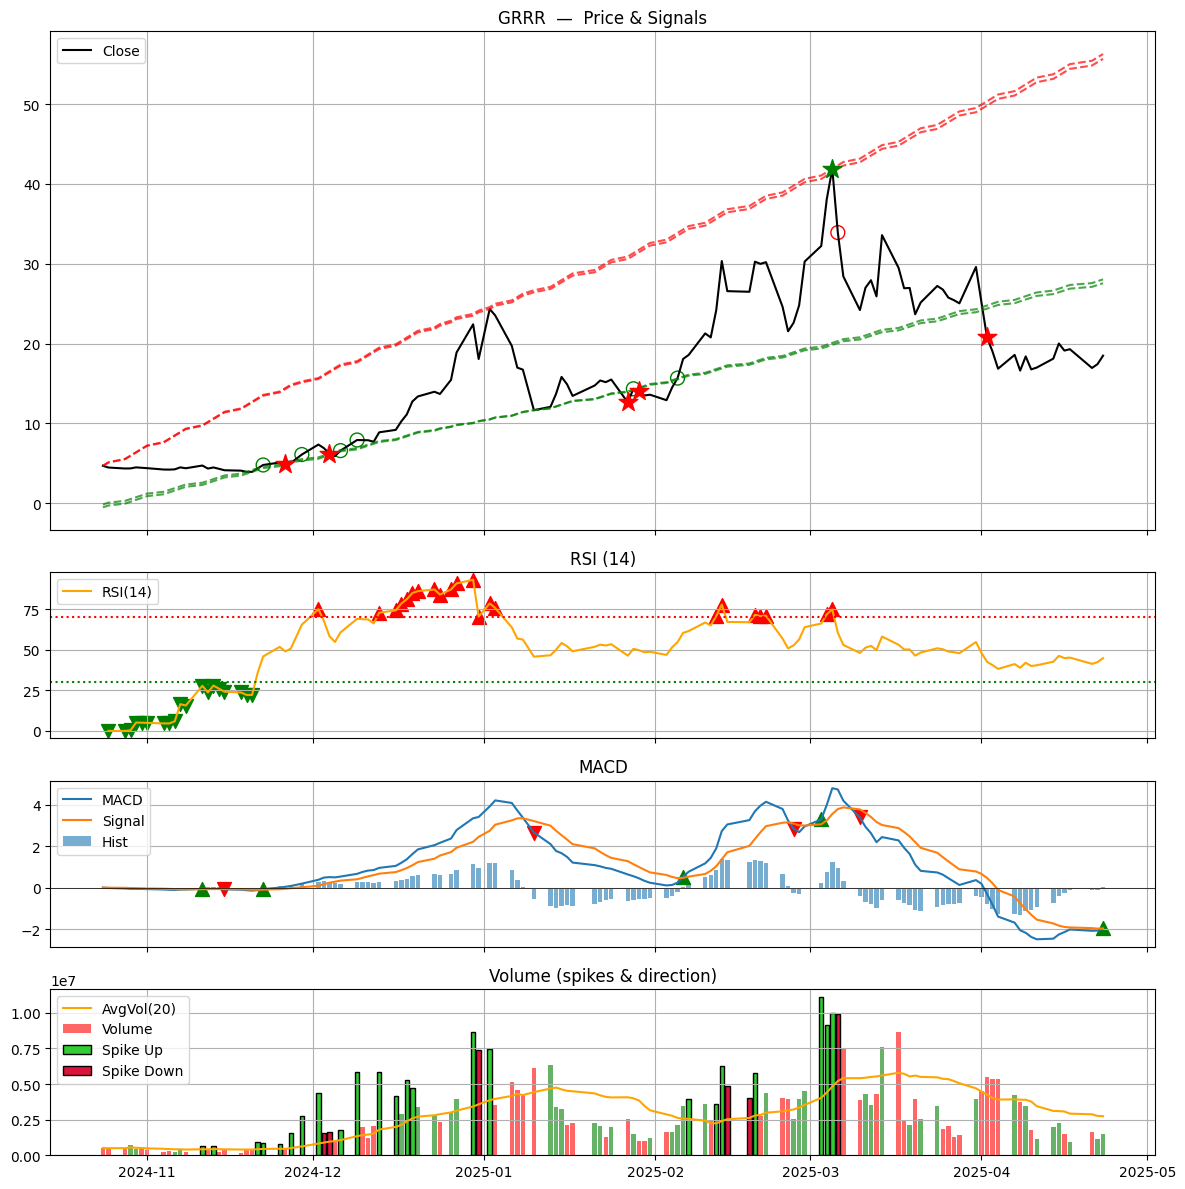

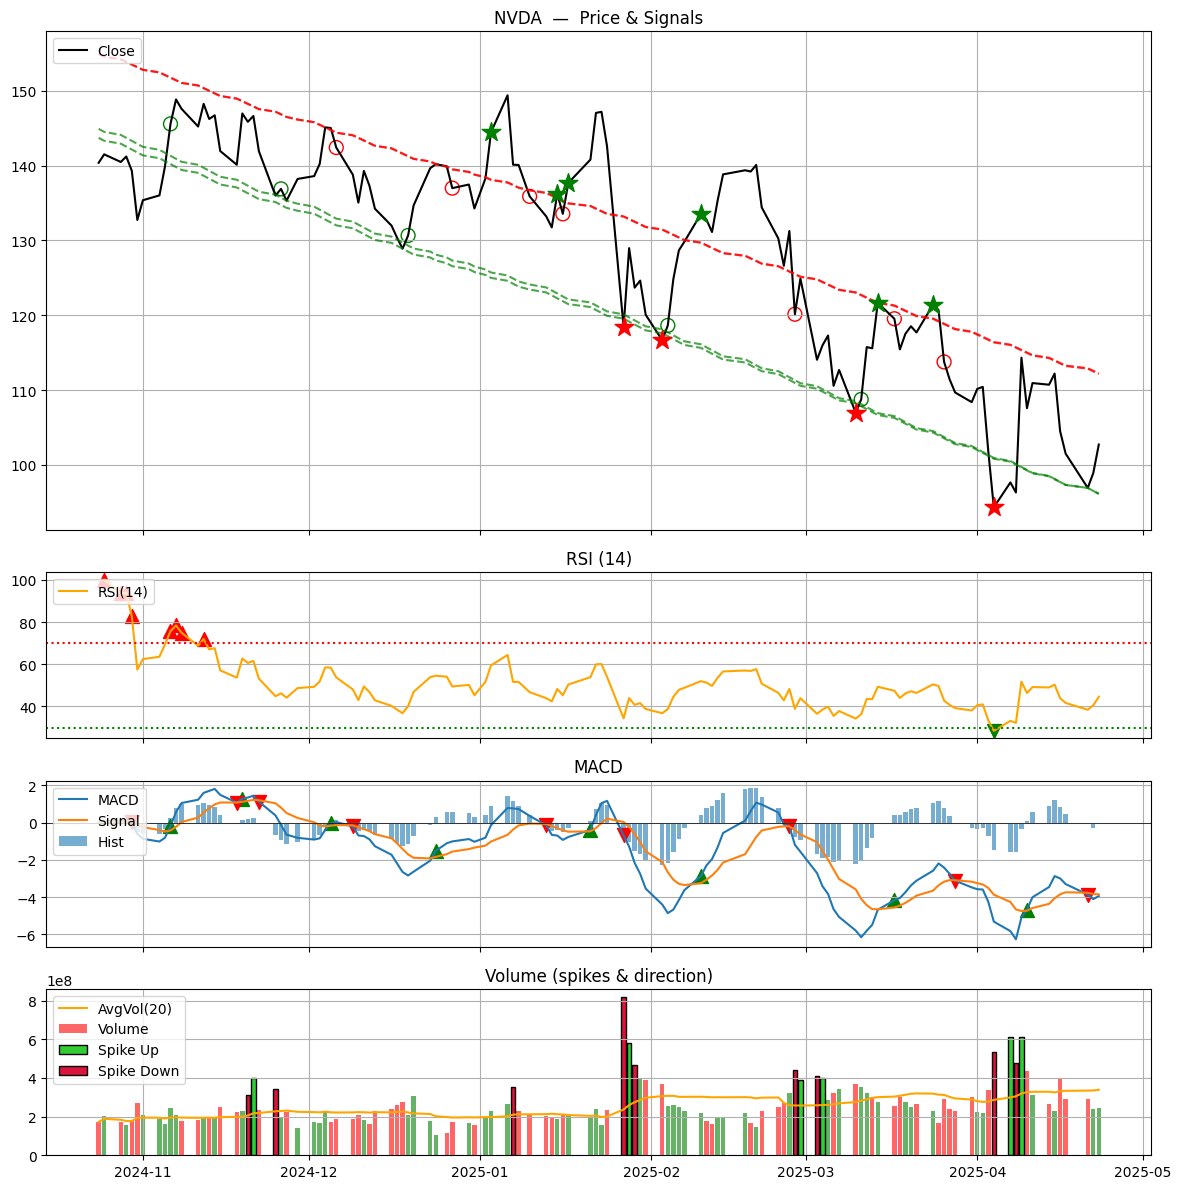

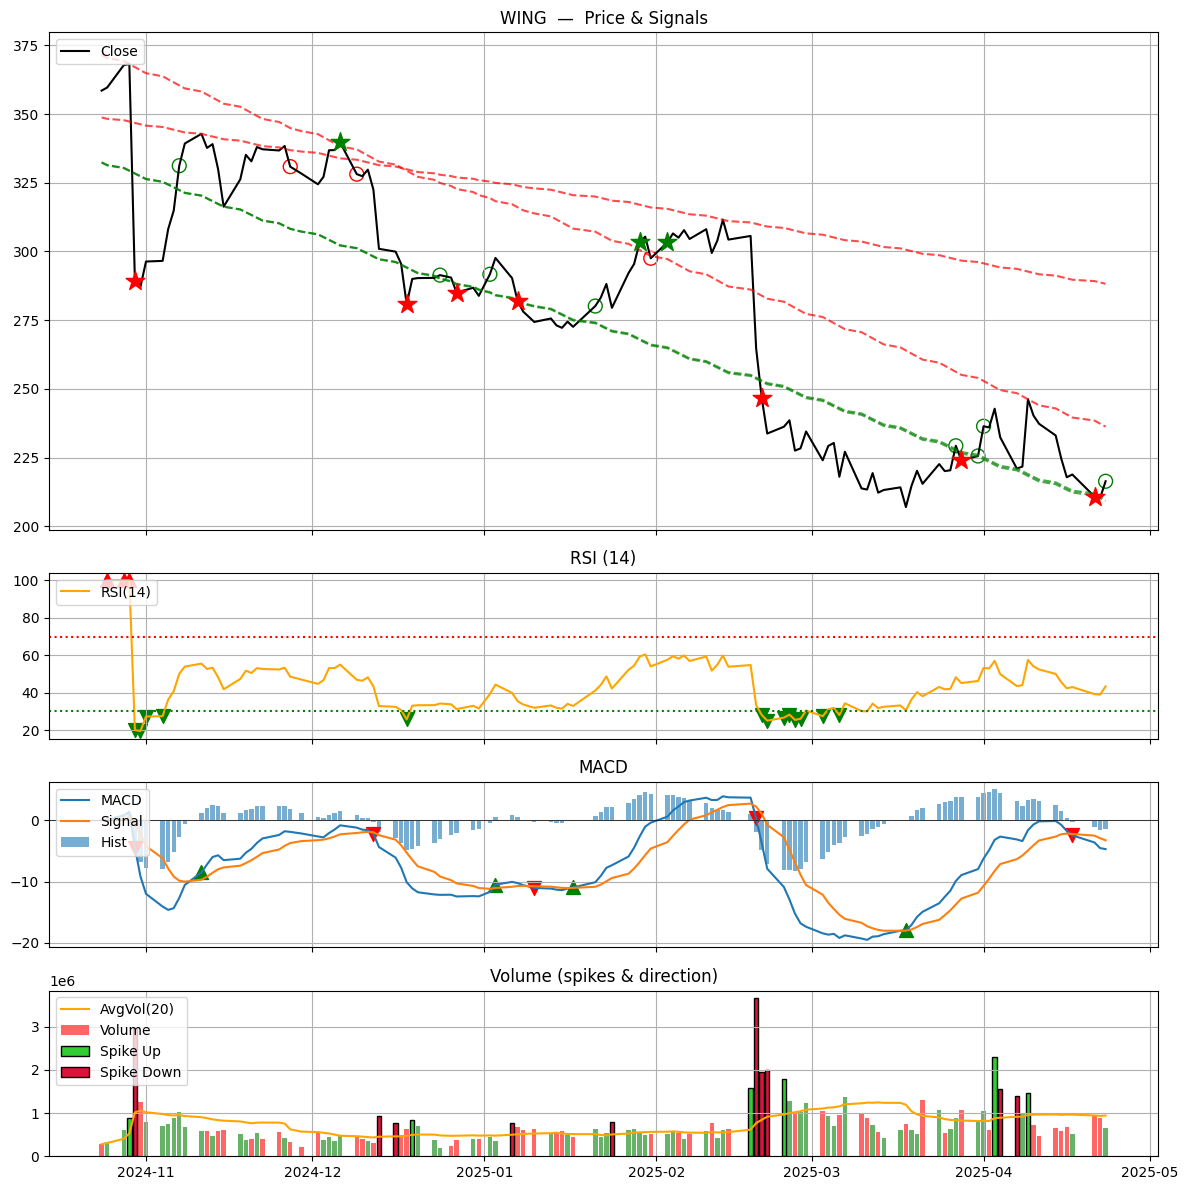

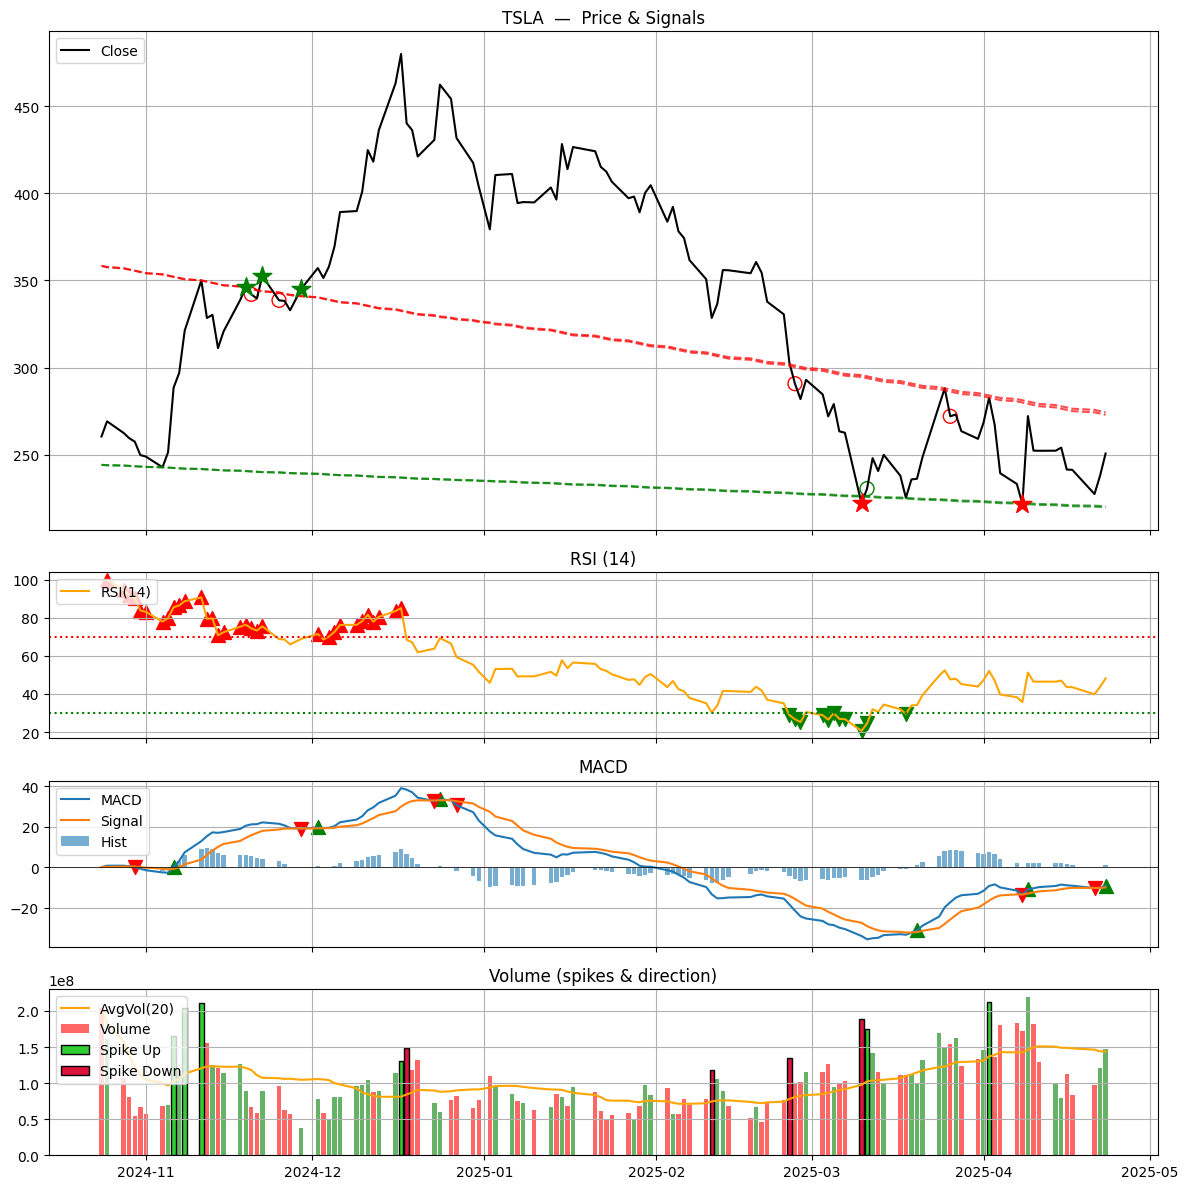

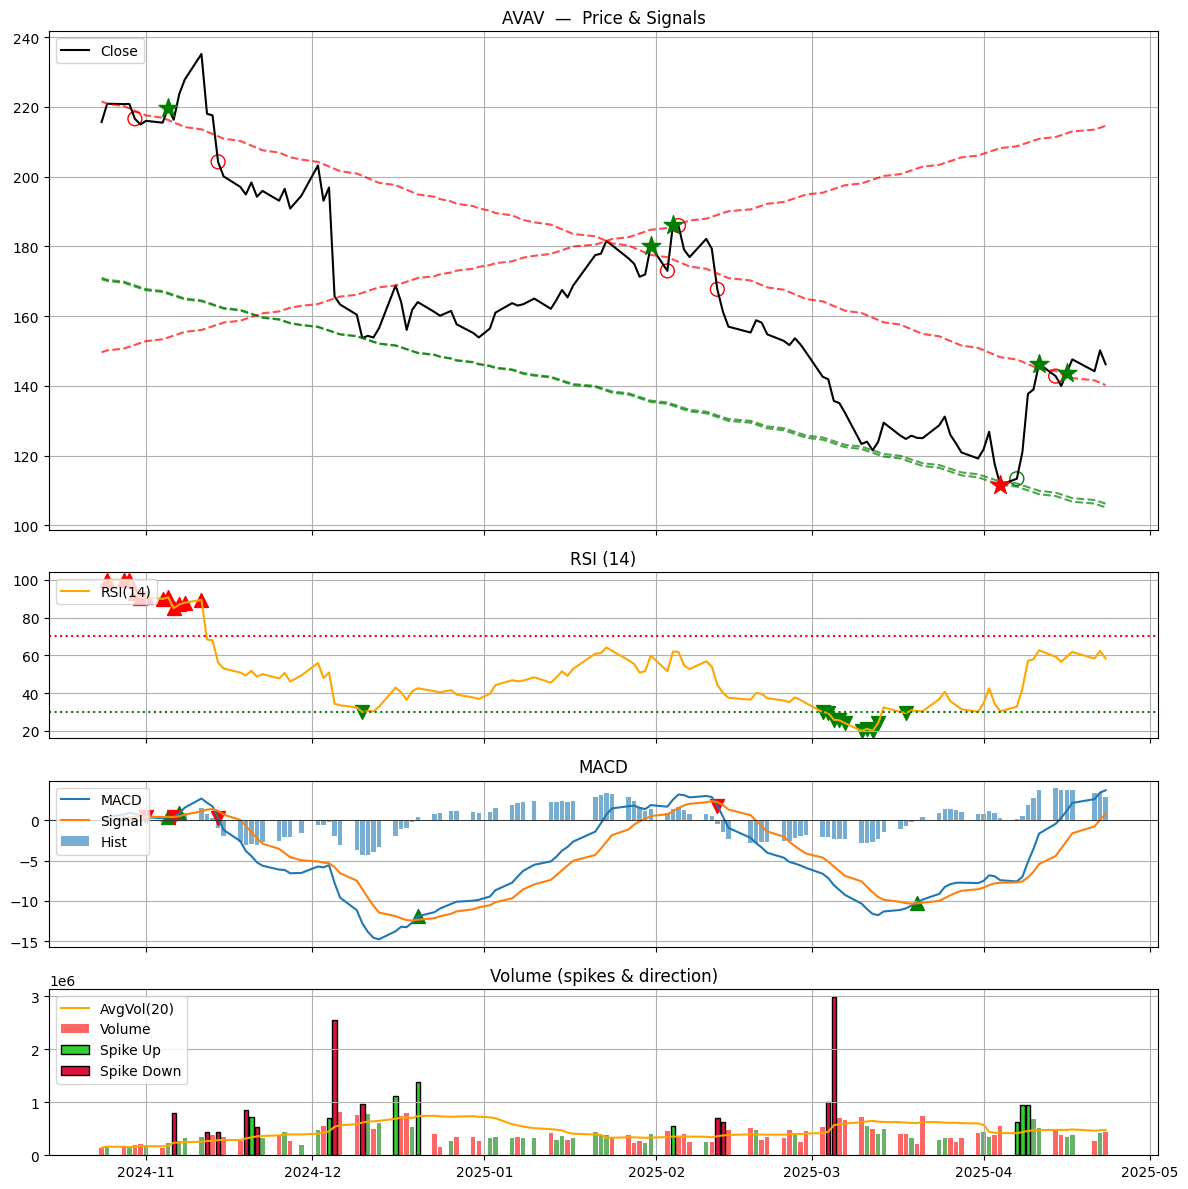

In [119]:
import os
import numpy as np
import matplotlib.pyplot as plt

# 1) Ensure the output folder exists
os.makedirs("scanner_output/graphs", exist_ok=True)

# 2) Sort tickers by backtest performance
metric    = "trend_return"  # or "breakout_return"
plot_order = summary_df.sort_values(metric, ascending=False).index.tolist()

# 3) Loop through all tickers, save each chart, show only top 5
for idx, ticker in enumerate(plot_order):
    df = data[ticker]

    # --- recompute top_sup/top_res for each ticker ---
    lows      = local_extrema(df, "min", order=5)
    highs     = local_extrema(df, "max", order=5)
    sup_cands = find_trendlines(df, lows,  tolerance=1.5, min_touches=3)
    res_cands = find_trendlines(df, highs, tolerance=1.5, min_touches=3)
    sup_cands.sort(key=lambda L:(L["touches"],L["span"]), reverse=True)
    res_cands.sort(key=lambda L:(L["touches"],L["span"]), reverse=True)
    top_sup, top_res = sup_cands[:2], res_cands[:2]

    # --- build the 4‐panel figure ---
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(
        4, 1, figsize=(12,12), sharex=True,
        gridspec_kw={"height_ratios":[3,1,1,1]}
    )
    x = np.arange(len(df), dtype=float)

    # 3.1) Price + trendlines + signals
    ax1.plot(df.date, df.close, color="black", label="Close")
    for L in top_sup + top_res:
        ax1.plot(
            df.date,
            L["slope"]*x + L["intercept"],
            linestyle="--",
            color="green" if L in top_sup else "red",
            alpha=0.7
        )

    # hollow circles: trendline-only breakouts
    tb = df["trendline_signal"]=="Buy"
    ts = df["trendline_signal"]=="Sell"
    ax1.scatter(df.date[tb], df.close[tb],
                facecolors="none", edgecolors="green", marker="o", s=100)
    ax1.scatter(df.date[ts], df.close[ts],
                facecolors="none", edgecolors="red", marker="o", s=100)

    # filled arrows: composite signals
    cb = df["composite_signal"]=="Buy"
    cs = df["composite_signal"]=="Sell"
    ax1.scatter(df.date[cb], df.close[cb],
                marker="^", color="green", s=200)
    ax1.scatter(df.date[cs], df.close[cs],
                marker="v", color="red",   s=200)

    # stars: breakthrough reversals
    ru = df["breakthrough_signal"]=="reversal_up"
    rd = df["breakthrough_signal"]=="reversal_down"
    ax1.scatter(df.date[ru], df.close[ru],
                marker="*", color="green", s=200, zorder=6)
    ax1.scatter(df.date[rd], df.close[rd],
                marker="*", color="red",   s=200, zorder=6)

    ax1.set_title(f"{ticker}  —  Price & Signals")
    ax1.legend(loc="upper left")
    ax1.grid(True)

    # 3.2) RSI panel
    ax2.plot(df.date, df.rsi_14, color="orange", label="RSI(14)")
    ax2.axhline(70, color="red", linestyle=":")
    ax2.axhline(30, color="green", linestyle=":")
    ov = df["rsi_signal"]=="oversold"
    ob = df["rsi_signal"]=="overbought"
    ax2.scatter(df.date[ov], df.rsi_14[ov],
                marker="v", color="green", s=100)
    ax2.scatter(df.date[ob], df.rsi_14[ob],
                marker="^", color="red",   s=100)
    ax2.set_title("RSI (14)")
    ax2.legend(loc="upper left")
    ax2.grid(True)

    # 3.3) MACD panel
    ax3.plot(df.date,       df.macd,        label="MACD")
    ax3.plot(df.date,       df.macd_signal, label="Signal")
    ax3.bar(df.date, df.macd_hist, alpha=0.6, label="Hist")
    ax3.axhline(0, color="black", linewidth=0.5)
    mb = df["macd_cross"]=="bull_cross"
    mr = df["macd_cross"]=="bear_cross"
    ax3.scatter(df.date[mb], df.macd[mb],
                marker="^", color="green", s=100)
    ax3.scatter(df.date[mr], df.macd[mr],
                marker="v", color="red",   s=100)
    ax3.set_title("MACD")
    ax3.legend(loc="upper left")
    ax3.grid(True)

    # 3.4) Volume panel
    df["up_bar"] = df["close"] > df["close"].shift(1)
    mu = df["vol_spike"] & df["up_bar"]
    md = df["vol_spike"] & ~df["up_bar"]
    ax4.bar(df.date, df.volume,
            color=np.where(df.up_bar, "green", "red"),
            alpha=0.6, label="Volume")
    ax4.bar(df.date[mu], df.volume[mu],
            color="limegreen", edgecolor="black", label="Spike Up")
    ax4.bar(df.date[md], df.volume[md],
            color="crimson",   edgecolor="black", label="Spike Down")
    ax4.plot(df.date, df.avg_vol, color="orange", label="AvgVol(20)")
    ax4.set_title("Volume (spikes & direction)")
    ax4.legend(loc="upper left")
    ax4.grid(True)

    plt.tight_layout()

    # 4) Save every chart by ticker
    out_file = f"scanner_output/graphs/{ticker}_fullchart.png"
    fig.savefig(out_file, dpi=150, bbox_inches="tight")

    # 5) Only display the top 5 in the notebook
    if idx < 5:
        plt.show()
    plt.close(fig)
